### В данном уроке мы выделим еще несколько потенциально важных фичей из изначального датасета и попробуем применить изученные методы отбора признаков к итоговому датасету.

In [3]:
import numpy as np
import pandas as pd

processed_data = pd.read_csv('5 processed_data.csv', index_col='id')
processed_data = processed_data.assign(log_trip_duration=np.log1p(processed_data['trip_duration']))
processed_data = processed_data.drop('trip_duration', axis=1)
processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration
id,,,,,
id2875421,1,930.399753,0,1.500479,6.122493
id2377394,0,930.399753,0,1.807119,6.498282
id3858529,1,930.399753,0,6.392080,7.661527
id3504673,1,930.399753,0,1.487155,6.063785
id2181028,1,930.399753,0,1.189925,6.077642


In [4]:
initial_data = pd.read_csv('1 дз taxi_dataset.csv')

initial_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N


In [5]:
initial_data.shape[0] == processed_data.shape[0]

True

In [6]:
### Вернем в датасет колонку pickup_datetime

initial_data = initial_data.set_index('id')

processed_data = pd.merge(processed_data, initial_data['pickup_datetime'],
                          left_index=True, right_index=True)

In [7]:
processed_data.columns

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'distance_km',
       'log_trip_duration', 'pickup_datetime'],
      dtype='object')

Напомним, **pickup_datetime** - время начала поездки.

Кажется, что в зависимости от месяца/дня недели/времени суток движение на дорогах может отличаться. Как из-за погодных условий, так и из-за загруженности транспорта. Поэтому, есть подозрение, что будет полезно выделить ряд признаков из колонки **pickup_datetime**. Давайте исследуем зависимость нашей таргетной переменной от указанных факторов.

In [8]:
processed_data['pickup_datetime'] = pd.to_datetime(processed_data['pickup_datetime'])

processed_data['date'] = processed_data.pickup_datetime.dt.date
processed_data['day_of_week'] = processed_data.pickup_datetime.dt.dayofweek
processed_data['hour'] = processed_data.pickup_datetime.dt.hour
processed_data['month'] = processed_data.pickup_datetime.dt.month

In [9]:
processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,pickup_datetime,date,day_of_week,hour,month
id,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,2016-03-14 17:24:55,2016-03-14,0,17,3
id2377394,0,930.399753,0,1.807119,6.498282,2016-06-12 00:43:35,2016-06-12,6,0,6
id3858529,1,930.399753,0,6.392080,7.661527,2016-01-19 11:35:24,2016-01-19,1,11,1
id3504673,1,930.399753,0,1.487155,6.063785,2016-04-06 19:32:31,2016-04-06,2,19,4
id2181028,1,930.399753,0,1.189925,6.077642,2016-03-26 13:30:55,2016-03-26,5,13,3


Исследуем, когда и сколько поездок было совершено. 

Начнем с графиков, показывающих количество поездок в зависимости от времени суток/даты и т.д.

Так же полезно сразу показать и среднее значение таргетной переменной.

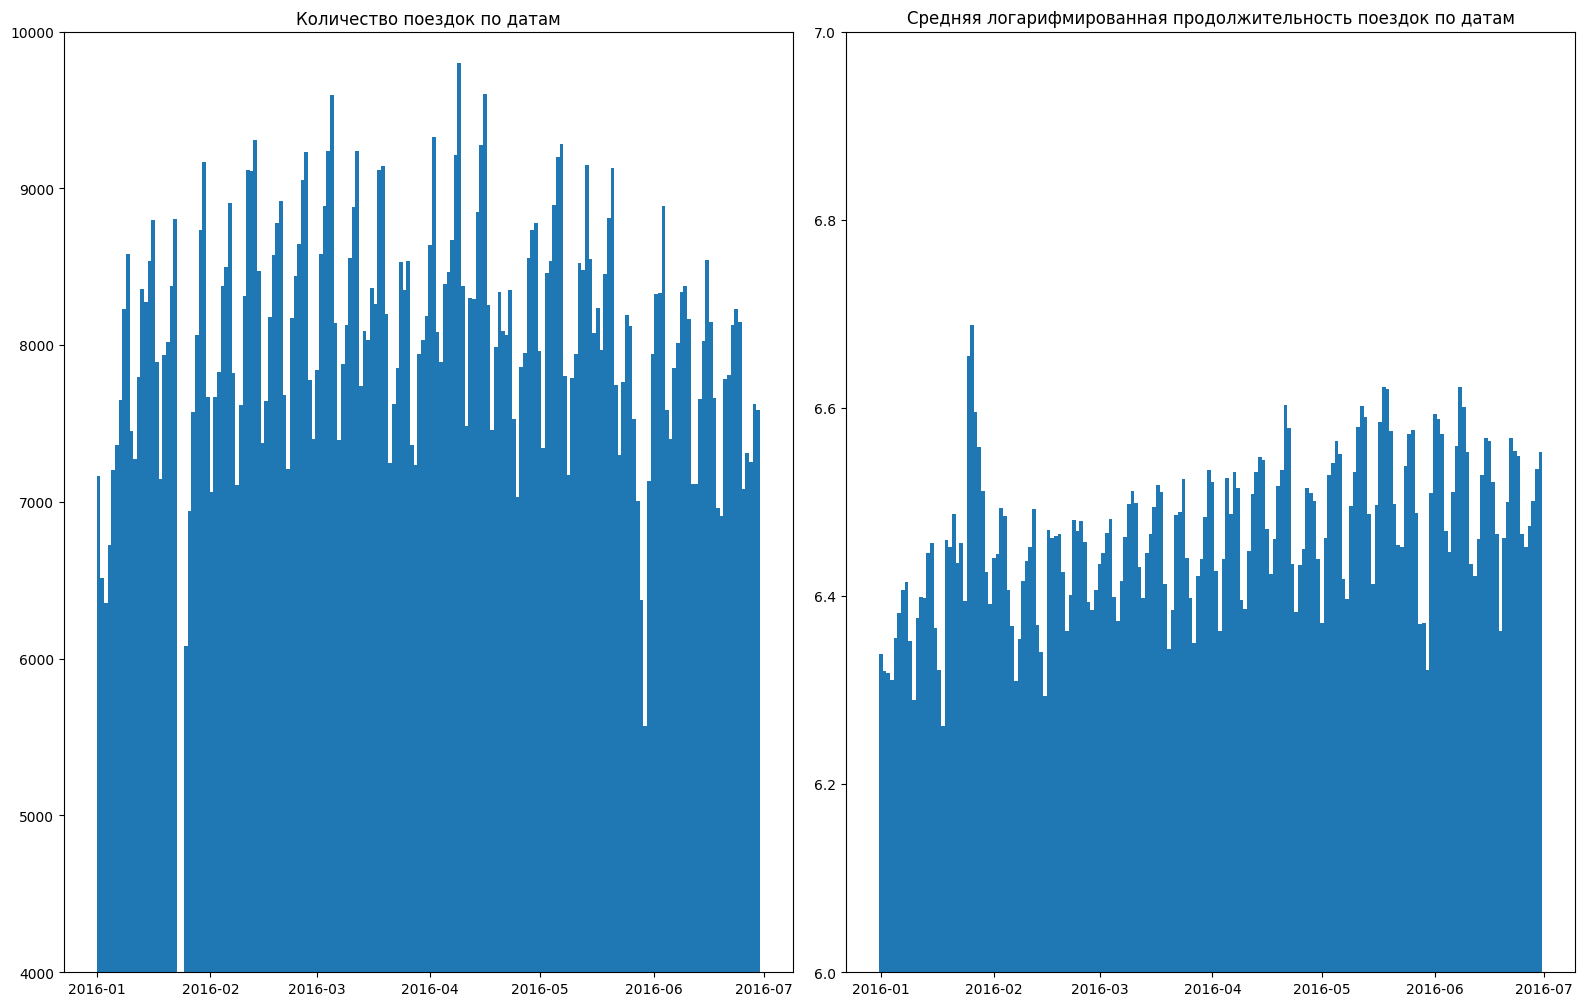

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()

fig.set_size_inches(16, 10)

ax_1 = fig.add_subplot(1, 2, 1)
plt.hist(processed_data['date'], bins=processed_data.date.unique().shape[0])
plt.ylim((4000, 10000))

ax_2 = fig.add_subplot(1, 2, 2)
plt.bar(sorted(list(processed_data['date'].unique())), 
        processed_data.groupby('date', as_index=False)['log_trip_duration'].mean()['log_trip_duration'],
        width=1)
plt.ylim((6, 7))

fig.tight_layout()

ax_1.set(title = 'Количество поездок по датам')
ax_2.set(title = 'Средняя логарифмированная продолжительность поездок по датам')

plt.show()

Кажется, что внутри недели есть некоторая зависимость таргета от дня недели. 

Такая же зависимость может оказаться и внутри дня (в завимости от часов).

Предлагаю исследовать эту зависимость подробнее.

Изобразите следующие графики зависимостей:

- Количество поездок/Средняя продолжительность поездки vs День недели
- Количество поездок/Средняя продолжительность поездки vs время суток
- Средняя продолжительность поездки vs время суток для каждого дня недели (например, нарисовав с разными цветами и, соответственно, легендами)
- Аналогичные графики, используя информацию о месяце, внутри которого была совершена поездка.
- Ящики с усами для различных: времени суток, дня недели, месяца

Используйте любые доступные инструменты pyplot!

Далее, на основе полученных результатов, мы будем принимать решение о создании новых признаков.

EDA можно использовать не только для того, чтобы понять, какие фичи можно убрать из датасета. Но и для выделения базовых признаков. Этим и займемся!

P.S. Сами графики мы проверять у Вас не будем. Зато для ответа на устные вопросы понадобятся, поэтому, в любом случае, крайне рекомендуем поупражняться. Поэтому рисовать все графики не обязательно - ограничьтесь теми, которые помогут Вам ответить на тестовые вопросы.

**Hint**: обратите внимание на сильную просадку в январе. Почему она могла произойти - можно прочитать <a href="https://en.wikipedia.org/wiki/January_2016_United_States_blizzard"> здесь</a>. В будущем можно будет создать бинарный признак "произошла ли поездка во время сильного снегопада".


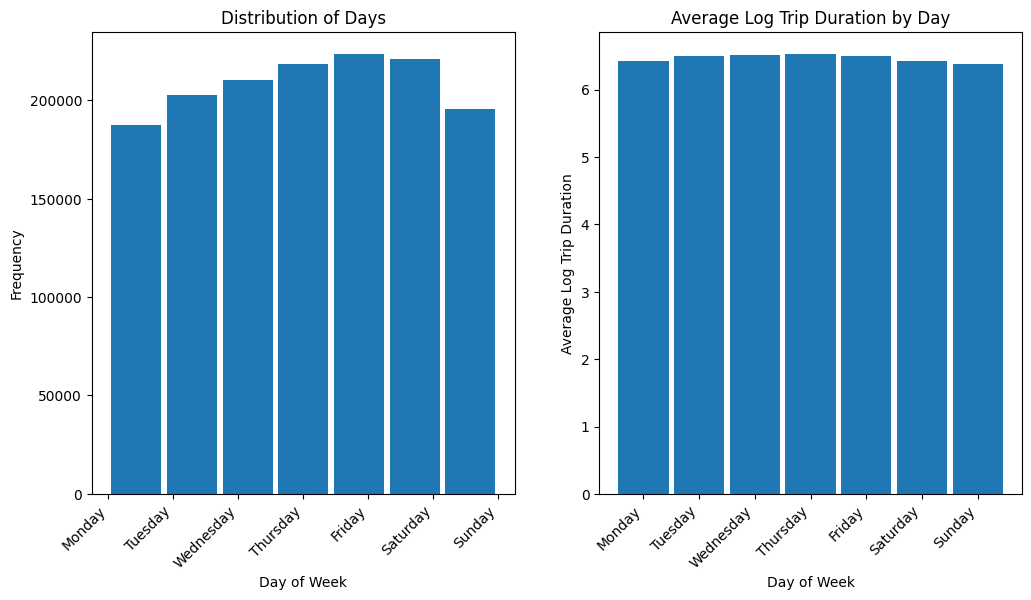

In [11]:
### Your code is here


import matplotlib.pyplot as plt

# Маппинг чисел к дням недели
day_mapping = {
    0: "Monday", 
    1: "Tuesday", 
    2: "Wednesday", 
    3: "Thursday", 
    4: "Friday", 
    5: "Saturday", 
    6: "Sunday"
}

# Создание фигуры и осей
fig = plt.figure(figsize=(12, 6))

# Гистограмма
ax_1 = fig.add_subplot(1, 2, 1)
plt.hist(
    processed_data['day_of_week'], 
    bins=processed_data['day_of_week'].nunique(),  # уникальное количество дней недели
    rwidth=0.9  # для улучшенной визуализации
)
ax_1.set_xticks(list(day_mapping.keys()))  # Установка отметок оси X
ax_1.set_xticklabels([day_mapping[day] for day in day_mapping.keys()],rotation=45,ha='right')  # Установка названий дней недели
ax_1.set_title('Distribution of Days')
ax_1.set_xlabel('Day of Week')
ax_1.set_ylabel('Frequency')

# Столбчатый график
ax_2 = fig.add_subplot(1, 2, 2)
unique_days = sorted(processed_data['day_of_week'].unique())
avg_log_duration = processed_data.groupby('day_of_week')['log_trip_duration'].mean()

plt.bar(
    [day_mapping[day] for day in unique_days],  # Используем текстовые названия дней недели
    avg_log_duration,
    width=0.9
)
ax_2.set_xticks(list(day_mapping.keys()))  # Установка отметок оси X
ax_2.set_xticklabels([day_mapping[day] for day in day_mapping.keys()],rotation=45,ha='right')  # Уст
ax_2.set_title('Average Log Trip Duration by Day')
ax_2.set_xlabel('Day of Week')
ax_2.set_ylabel('Average Log Trip Duration')



#ax_3 = fig.add_subplot(2,2,1)
#plt.
#fig.tight_layout()#

#ax_1.set(title = 'Количество поездок по дням недели')
#ax_2.set(title = 'Средняя логарифмированная продолжительность поездок по дням недели')

plt.show()


Кажется, что полученные выводы из графиков выше достаточны для того, чтобы посчитать признаки, связанные с временем/датой поездки, достаточно важными. На их основе выделим еще пару.

Добавьте следующие бинарные признаки:


1. Была ли в день поездки буря (основываясь на единственном обнаруженном таком дне)
2. Является ли время поездки статистически самым проблемным, то есть час пиком?

Для создания 2ой фичи используйте следующую логику: посчитаем для каждой пары "день недели"-"время суток" среднее значение таргета. Найдем топ-10 самых "больших" пар. Если поездка была совершена во входящее в этот топ время, то ставим 1. Иначе - 0. Получается бинарный признак.

P.S. назовите колонки **anomaly** и **traffic_jam**

In [12]:
### Создадим первый бинарный признак
### Your code is here


In [13]:
### Создадим второй бинарный признак
### Your code is hereimport pandas as pd

# Шаг 1: Найти день с аномалией (без поездок)
trips_per_day = processed_data.groupby('date').size()
stormy_day = trips_per_day[trips_per_day == 0].index.tolist()

# Добавляем признак anomaly
processed_data['anomaly'] = processed_data['date'].apply(lambda x: 1 if x in stormy_day else 0)

# Шаг 2: Средние значения таргета по парам "день недели" - "час"
mean_target_by_pair = (
    processed_data.groupby(['day_of_week', 'hour'])['log_trip_duration']
    .mean()
    .reset_index()
    .rename(columns={'log_trip_duration': 'mean_log_trip_duration'})
)

# Топ-10 самых загруженных пар
top_10_pairs = mean_target_by_pair.nlargest(10, 'mean_log_trip_duration')[['day_of_week', 'hour']]

# Преобразуем топ-10 в множество для удобства проверки
top_10_pairs_set = set(
    (row['day_of_week'], row['hour']) for _, row in top_10_pairs.iterrows()
)

# Шаг 3: Добавляем признак traffic_jam
processed_data['traffic_jam'] = processed_data.apply(
    lambda row: 1 if (row['day_of_week'], row['hour']) in top_10_pairs_set else 0,
    axis=1
)


In [14]:
processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,pickup_datetime,date,day_of_week,hour,month,anomaly,traffic_jam
id,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,2016-03-14 17:24:55,2016-03-14,0,17,3,0,0
id2377394,0,930.399753,0,1.807119,6.498282,2016-06-12 00:43:35,2016-06-12,6,0,6,0,0
id3858529,1,930.399753,0,6.392080,7.661527,2016-01-19 11:35:24,2016-01-19,1,11,1,0,1
id3504673,1,930.399753,0,1.487155,6.063785,2016-04-06 19:32:31,2016-04-06,2,19,4,0,0
id2181028,1,930.399753,0,1.189925,6.077642,2016-03-26 13:30:55,2016-03-26,5,13,3,0,0


Теперь колонки **pickup_datetime**, **date** можно убрать. А про оставшиеся **day_of_week**, **hour**, **month** необходимо подумать:

- С одной стороны, первые две можно убрать, так как на их основе была создана колонка **traffic_jam**
- С другой стороны, зависимость с колонкой **traffic_jam** нелинейная, поэтому можно попробовать использовать все фичи в комбинации. Конечно, лучше попробовать оба варианта и проэкспериментировать, но ради упрощения - оставим все колонки. Хоть **day_of_week**, **hour** и описываются числами, мы понимаем, что это скорее категориальные фичи. Потому что, например, отношение между 23:00 и 00:00 не такое же, как между числами 23 и 0. Закодируем их с помощью OneHotEncoder. 
- Последняя (**month**) очевидно категориальная. Можно закодировать ее тоже через OneHotEncoder.

In [15]:
processed_data = processed_data.drop(['pickup_datetime', 'date'], axis=1)

In [16]:
### Делаем OneHotEncoding и конкатим с processed_data


encoded_df = pd.get_dummies(processed_data,columns=['day_of_week', 'hour', 'month'])
encoded_df = encoded_df.drop(columns=['day_of_week_0','hour_0','month_1'])
encoded_df

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
id2377394,0,930.399753,0,1.807119,6.498282,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
id3858529,1,930.399753,0,6.392080,7.661527,0,1,True,False,False,...,False,False,False,False,False,False,False,False,False,False
id3504673,1,930.399753,0,1.487155,6.063785,0,0,False,True,False,...,True,False,False,False,False,False,False,True,False,False
id2181028,1,930.399753,0,1.189925,6.077642,0,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id2376096,1,1053.529749,0,1.226296,6.658011,0,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
id1049543,0,930.399753,0,6.056935,6.486161,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
id2304944,1,930.399753,0,7.832952,6.639876,0,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False


Что же, мы с Вами научились с помощью EDA визуализаций понимать важность признаков не только постфактум, но и до того, как сформировался финальный датасет - на этапе **выделения базовых фичей**.

Обратимся теперь к методам фильтрации - например, применим корреляционный анализ для одной пары фичей, чтобы понять, нет ли относительно этих колонок в нашем датасете избытка информации. 

Вспомним так же изначальные вещественные признаки - distance_km, passenger_count

Посчитайте корреляцию между ними. Есть ли какие-то основания для беспокойства?

In [17]:
### Your code is here

encoded_df[['passenger_count','distance_km']].corr()

,passenger_count,distance_km
passenger_count,1.000000,0.016596
distance_km,0.016596,1.000000


In [18]:
len(encoded_df.columns)

41

In [20]:
### На данный момент у нас 41 фича
### Представим, что хочется сократить их количество до 5.
### Воспользуемся для этим каким-нибудь методом обертки
### Например, метод прямого отбора

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

x = encoded_df.drop(columns='log_trip_duration')
y = encoded_df['log_trip_duration']

model = LinearRegression()

sfs = SequentialFeatureSelector(model,n_features_to_select=5)
sfs.fit(x,y)

sfs.get_feature_names_out()

array(['distance_km', 'traffic_jam', 'day_of_week_6', 'hour_5', 'hour_6'],
      dtype=object)

In [21]:
### Представим, что мы с Вами ничего не знаем про Кросс-Валидацию и отложенную выборку
### Замерьте качество линейной регрессии на данных фичах
### Сильно ли оно отличается от полученного на Кросс-Валидации в прошлом уроке в ДЗ?

test_df = encoded_df[sfs.get_feature_names_out()]
model = LinearRegression()
model.fit(test_df,y)
preds = model.predict(test_df)
np.mean((preds-y)**2)

np.float64(0.41540002340782545)